In [3]:
import os
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.cluster import KMeans


BASE_PATH = os.path.dirname(os.getcwd())

É possível fazer um apanhado do preço do papel a partir deste [site](https://www.cepea.esalq.usp.br/br/categoria/florestal.aspx), contudo é um trabalho braçal reunir todas as informações necessárias.

In [26]:
# Carrega dataset com preços
dataset = pd.read_csv(f"{BASE_PATH}/data/hqs/datasets/volumes.csv", sep="\t")

# Remove as editoras internacionais
dataset = dataset[(dataset.publisher != "VIZ MEDIA LLC") & (dataset.publisher != "VIZ MEDIA")]

# Padroniza nome de editora que veio em formatos diferentes
def conv_publisher(name: str):
    if name in ["MYTHOS", "KAZÉ MANGA", "VIZ MEDIA", "VIZ MEDIA LLC", "CARLSEN VERLAG GMBH", "GOLLANCZ", "PIXEL"]:
        return "OUTROS"
    elif name == "EDITORA JBC":
        return "JBC"
    else:
        return name

dataset.publisher = dataset.publisher.apply(lambda x: conv_publisher(x))

# Padroniza o formato de capa
conv_format = {
    "CAIXAS E COLEÇÕES": "OUTROS",
    "CANOA, GRAMPEADO OU COSTURADO": "CAPA COMUM",
    "CAPA CLÁSSICA COM BLOCAGEM": "CAPA COMUM",
    "CAPA COMUM": "CAPA COMUM",
    "CAPA DURA": "CAPA DURA",
    "CAPA FLEXÍVEL": "CAPA COMUM",
    "CAPA MOLE": "CAPA COMUM",
    "CAPA REFORÇADA": "CAPA COMUM",
    "CAPÍTULOS AVULSOS": "OUTROS",
    "ENCADERNAÇÃO COM GRAMPOS": "OUTROS",
    "LIVRO (CAPA TANKOBON)": "CAPA COMUM",
    "LIVRO CARTONADO": "CAPA COMUM",
    "LIVRO COM BRINDE": "CAPA COMUM",
    "LIVRO DE BOLSO": "CAPA COMUM",
    "ACABAMENTO ESPECIAL": "CAPA COMUM",
    "AGENDA OU CALENDÁRIO" : "OUTROS",
    "ESTAMPADO": "CAPA COMUM",
}
dataset.format = dataset.format.apply(lambda x: conv_format[x])

# Faz a remoção de registros anômalos no sentido de quantidade de páginas,
# que normalmente representam anúncios de kits de volumes. Também remove
# registros com categoria "OUTROS", que são campos não identificados.
dataset = dataset.loc[(dataset.pages < 800)]\
    .loc[(dataset.format != "OUTROS")]\
    .loc[(dataset.publisher != "OUTROS")]

# Extrai o ano de lançamento
dataset["release_year"] = dataset.release_date.apply(lambda x: int(x.split("-")[0]))

# Remove anomalias de tamanho
dataset = dataset.loc[dataset["height"] < 60]

## Distribuição

Pela apresentação, fica evidente uma maior concentração de volumes nos últimos 2 anos. Considerando os acontecimentos globais do mercado, três explicações são possíveis:

1. As editoras cresceram e expandiram o seu catálogo de produtos;
2. Ocorreu uma série de reimpressões de volumes antigos;
3. Após 2 anos de lançamento, os volumes passam a não estar facilmente disponíveis na Amazon

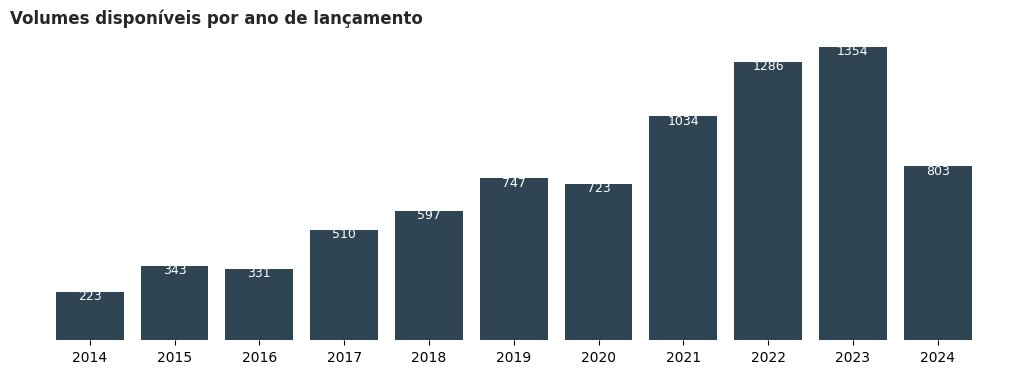

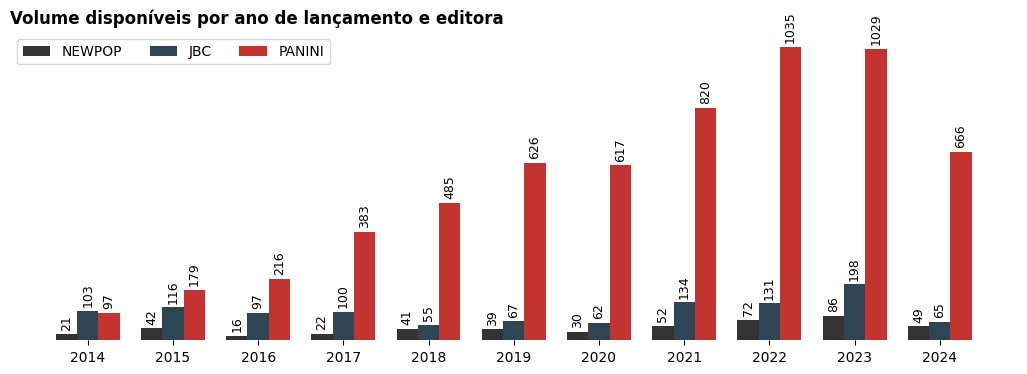

In [5]:
# Define o range de anos que serão avaliados
selected_years = list(range(2014, 2025))

# Calcula a quantidade de volumes disponíveis em cada ano
volumes_count = [list(dataset["release_year"]).count(y) for y in selected_years]

# Cria o gráfico com as configurações básicas
plt.figure(figsize=(13, 4))
ax = plt.subplot(111)
ax.set(frame_on=False)

ax.set_title("Volumes disponíveis por ano de lançamento", color="#272727", fontdict={"fontweight": 800}, loc="left")
ax.axes.get_yaxis().set_visible(False)
ax.set_xticks(selected_years)

# Configura as barras
ax.bar(selected_years, volumes_count, color="#2f4554")

# Método 1 para adicionar labels nas colunas
for rect, label in zip(ax.patches, volumes_count):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height - 50,
        label,
        ha="center",
        va="bottom",
        fontsize=9,
        color="#fff"
    )
plt.show()

# Define as editoras, colres e tamanhos de colunas
publishers = ["NEWPOP", "JBC", "PANINI"]
colors = ["#333333", "#2f4554", "#c33431"]
volumes_count = []
width = 0.25

# Calcula os volumes disponíveis para cada editora
for publisher in publishers:
    subset = dataset.loc[(dataset.publisher == publisher)]
    volumes_count.append([list(subset.release_year).count(y) for y in selected_years])

# Configuração inicial do gráfico
plt.figure(figsize=(13, 4))
ax = plt.subplot(111)
ax.set(frame_on=False)

ax.set_title("Volume disponíveis por ano de lançamento e editora", fontdict={"fontweight": 800}, loc="left")
ax.axes.get_yaxis().set_visible(False)
ax.set_xticks(selected_years)

# Faz o desenho das barras para as editora
for i in range(0, len(volumes_count)):
    x = [s - width + i * width for s in selected_years]
    rect = ax.bar(x, volumes_count[i], width, label=publishers[i], color=colors[i])
    ax.bar_label(rect, padding=3, fontsize=9, rotation=90)

ax.legend(loc="upper left", ncols=len(publishers))
plt.show()

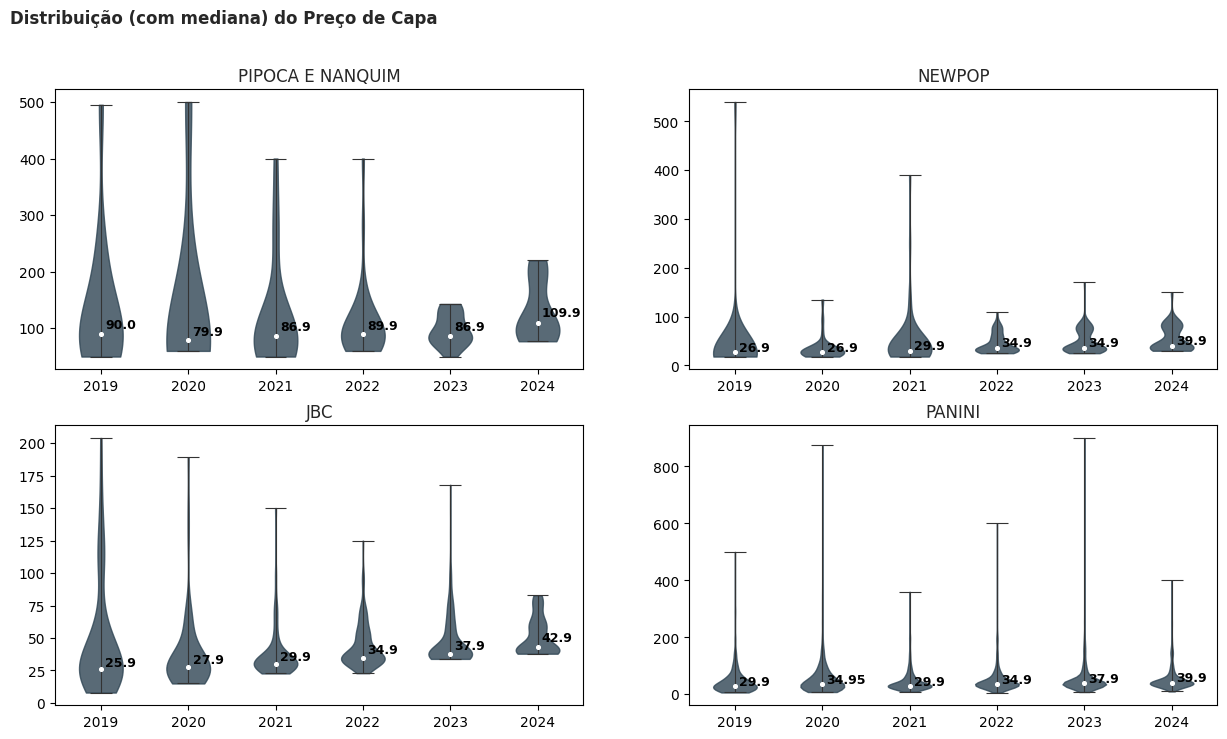

In [6]:
# Define o range de anos que serão avaliados
selected_years = list(range(2019, 2025))

# Cria a configuração básica dos gráficos
ax: List[List[Axes]]
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Distribuição (com mediana) do Preço de Capa", color="#272727", weight=800, ha="left", x=0.095)

# Percorre as editoras
publishers = ["PIPOCA E NANQUIM", "NEWPOP", "JBC", "PANINI"]
axes = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]

for publisher, axs in zip(publishers, axes):
    # Filtra dados e recupera preços
    subset = dataset.loc[dataset.publisher == publisher]
    x = [subset.loc[subset.release_year == y]["full_price"].values for y in selected_years]
    medians = [np.percentile(x[i], 50) for i in range(0, len(x))]

    # Organiza o gráfico
    indices = [i + 1 for i in range(0, len(selected_years))]
    parts = axs.violinplot(x, showmedians=False, showextrema=True)
    axs.set_title(f"{publisher}", color="#272727")
    axs.set_xticks(indices, labels=selected_years)

    # Customização do corpo do violinplot
    for p in parts["bodies"]:
        p.set_color("#2f4554")
        p.set_alpha(0.8)

    # Customização dos elementos de estatística do violinplot
    for partname in ["cbars", "cmins", "cmaxes"]:
        parts[partname].set_edgecolor("#333333")
        parts[partname].set_linewidth(0.8)

    # Adição de itens descritivos
    axs.scatter(indices, medians, marker="o", color="white", s=7, zorder=3)
    for i in range(0, len(indices)):
        axs.text(indices[i] + 0.05, medians[i] * 1.1, medians[i], fontdict={"fontweight": 800, "fontsize": 9})

plt.show()

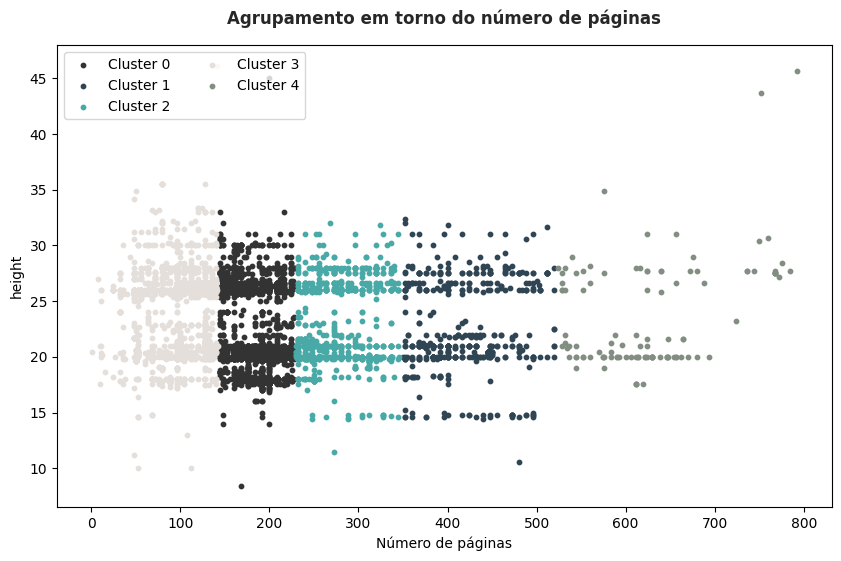

In [68]:
# Criação dos clusters
n_clusters = 5
columns = ["pages", "height"]
colors = ["#333333", "#2F4554", "#48A9A6", "#E4DFDA", "#838E83", "#D4B483"]
clustering = KMeans(n_clusters=n_clusters, init="k-means++")

clustering.fit(dataset[columns].values)
dataset["len_cluster"] = clustering.predict(dataset[columns].values)

# Visualização gráfica dos dados
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for i in range(0, n_clusters):
    subset = dataset.loc[dataset.len_cluster == i]
    x = subset[columns[0]].values
    y = subset[columns[1]].values
    ax.scatter(x, y, s=10, c=colors[i], label=f"Cluster {i}")
    
    ax.set_xlabel("Número de páginas")
    ax.set_ylabel(columns[1])

ax.legend(loc="upper left", ncols=n_clusters // 2)
ax.set_title("Agrupamento em torno do número de páginas", color="#272727", fontdict={"fontweight": 800}, loc="center", pad=15)
plt.show()

In [42]:
dataset.head()

,format,download_at,full_price,name,publisher,release_date,pages,dimensions,ISBN-10,ISBN-13,customers_review,about,height,width,depth,release_year,len_cluster
0,CAPA COMUM,2024-04-15T15:02:47.382924,89.9,Calendar - Edição Especial,JBC,2023-08-9,448,15 x 2 x 21 cm,6555944803,978-6555944808,4.0,Esta é uma estória de mudanças e crescimento e...,21.0,15.0,2.0,2023,5
1,CAPA COMUM,2024-04-09T11:36:51.351174,78.9,One Piece Vol. 1,PANINI,2024-05-20,192,20 x 13.6 x 1 cm,8573516976,978-8573516975,4.8,A tripulação pirata mais famosa dos quadrinhos...,20.0,13.6,1.0,2024,0
2,CAPA COMUM,2024-04-15T15:02:57.405480,44.9,Quack! - Vol. 01,JBC,2023-08-9,192,15 x 1 x 21 cm,6555944676,978-6555944679,8.0,O jovem Baltazar Drumont vem de uma família le...,21.0,15.0,1.0,2023,0
3,CAPA COMUM,2024-04-09T11:37:05.487100,36.9,Shangri-la Frontier - 02,PANINI,2024-05-20,200,13.7 x 1.5 x 20 cm,6559604306,978-6559604302,4.9,"Sunraku decide encarar o jogo divino ""Shangri-...",20.0,13.7,1.5,2024,0
4,CAPA COMUM,2024-04-09T11:37:20.575021,36.9,Shangri-la Frontier Vol. 1,PANINI,2024-05-20,208,13.7 x 1.8 x 20 cm,6559606872,978-6559606870,4.8,"Rakurou Hizutome, um rapaz apaixonado por ""jog...",20.0,13.7,1.8,2024,0


In [6]:
from statsmodels.multivariate.manova import MANOVA
fit = MANOVA.from_formula("publisher + pages + release_year + format ~ full_price", data=dataset)
print(fit.mv_test())

                                  Multivariate linear model
                                                                                              
----------------------------------------------------------------------------------------------
       Intercept                Value         Num DF   Den DF          F Value          Pr > F
----------------------------------------------------------------------------------------------
          Wilks' lambda                0.0000 8.0000 8872.0000 1426997710501107456.0000 0.0000
         Pillai's trace                1.0000 8.0000 8872.0000 1426997710501107456.0000 0.0000
 Hotelling-Lawley trace 1286742750677283.5000 8.0000 8872.0000 1426997710501107456.0000 0.0000
    Roy's greatest root 1286742750677283.5000 8.0000 8872.0000 1426997710501107456.0000 0.0000
----------------------------------------------------------------------------------------------
                                                                                     

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [8]:
def cluster_page(value: int):
    if value < 100:
        return "C1"
    elif value < 250:
        return "C2"
    elif value < 450:
        return "C3"
    else:
        return "C4"
dataset["pages_cluster"] = dataset.pages.apply(lambda x: cluster_page(x))

In [9]:
modelo = ols("full_price ~ C(publisher) + C(pages_cluster) + C(release_year) + C(publisher):C(pages_cluster):C(release_year)", data=dataset).fit()
anova_results = sm.stats.anova_lm(modelo, typ=3)
print(anova_results)

                                                     sum_sq      df  \
Intercept                                      6.409575e+03     1.0   
C(publisher)                                   5.348468e+04     4.0   
C(pages_cluster)                               1.770770e+05     3.0   
C(release_year)                                3.668194e+04    28.0   
C(publisher):C(pages_cluster):C(release_year)  1.649697e+07   544.0   
Residual                                       1.953848e+07  8648.0   

                                                       F        PR(>F)  
Intercept                                       2.836966  9.215409e-02  
C(publisher)                                    5.918263  9.415378e-05  
C(pages_cluster)                               26.125564  8.126944e-17  
C(release_year)                                 0.579855  9.620494e-01  
C(publisher):C(pages_cluster):C(release_year)  13.422400  0.000000e+00  
Residual                                             NaN        

/media/bruno/Arquivos/Desenvolvimento/SomeAnalysis/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 544, but rank is 213
  warnings.warn('covariance of constraints does not have full '


In [12]:
anova_results

,sum_sq,df,F,PR(>F)
Intercept,6.409575e+03,1.0,2.836966,9.215409e-02
C(publisher),5.348468e+04,4.0,5.918263,9.415378e-05
C(pages_cluster),1.770770e+05,3.0,26.125564,8.126944e-17
C(release_year),3.668194e+04,28.0,0.579855,9.620494e-01
C(publisher):C(pages_cluster):C(release_year),1.649697e+07,544.0,13.422400,0.000000e+00
Residual,1.953848e+07,8648.0,NaN,NaN


In [11]:
# Exibir um gráfico de barras com os preços médios por editora nos últimos 5 anos
# Exibir um gráfico de barras com a quantidade de lançamentos por editora nos últimos 5 anos

# Fazer teste anova para todas
# Fazer teste de média para cada par